<a href="https://colab.research.google.com/github/jiyoung37/customer_segmentation/blob/main/Customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries

In [1]:
import numpy as np                                # For numerical operations and handling arrays
import pandas as pd                               # For data manipulation and analysis
import seaborn as sns                             # For statistical data visualization (e.g., heatmaps)
import matplotlib.pyplot as plt                   # For visualizing data
from sklearn.preprocessing import MinMaxScaler    # For scaling the data (Min-Max)
from sklearn.preprocessing import StandardScaler  # For scaling the data (Standardization)
from sklearn.cluster import KMeans                # For K-Means clustering
from sklearn.cluster import DBSCAN                # For DBSCAN clustering
from sklearn.metrics import silhouette_score      # For evaluating clustering performance
from sklearn.manifold import TSNE                 # For dimensionality reduction (t-SNE)
from sklearn.decomposition import PCA
import os                                         # For Traversing through directories to find and access files (useful for Kaggle Kernels)
import warnings


# Ignore all warnings
warnings.filterwarnings('ignore')

# Data preparation

Download file from Github

In [2]:
# Load dataset from Github
import pandas as pd

# Use the correct raw GitHub link
url = "https://raw.githubusercontent.com/jiyoung37/customer_segmentation/main/Online%20Retail.xlsx"

# Read Excel file with the correct engine
df = pd.read_excel(url, engine="openpyxl")

# Display first few rows
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Data overview

In [3]:
# data shape
print("data shape:",df.shape)

data shape: (541909, 8)


In [4]:
# missing data
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


# Data cleaning

## 1. Check duplicates

In [50]:
df.StockCode = df.StockCode.astype(str)

duplicate_counts = df.groupby(['InvoiceNo', 'CustomerID', 'StockCode', 'Quantity', 'InvoiceDate']).size().reset_index(name='Count')
print(duplicate_counts)

# Filter to show only duplicate rows (Count > 1)
true_duplicates = duplicate_counts[duplicate_counts['Count'] > 1]
print(true_duplicates)

print(df[(df['InvoiceNo']== '536409') & (df['StockCode']== '21866')])


       InvoiceNo  CustomerID StockCode  Quantity         InvoiceDate  Count
0         536365       17850     21730         6 2010-12-01 08:26:00      1
1         536365       17850     22752         2 2010-12-01 08:26:00      1
2         536365       17850     71053         6 2010-12-01 08:26:00      1
3         536365       17850    84029E         6 2010-12-01 08:26:00      1
4         536365       17850    84029G         6 2010-12-01 08:26:00      1
...          ...         ...       ...       ...                 ...    ...
536475   C581490       14397     23144       -11 2011-12-09 09:57:00      1
536476   C581499       15498         M        -1 2011-12-09 10:28:00      1
536477   C581568       15311     21258        -5 2011-12-09 11:57:00      1
536478   C581569       17315     20979        -5 2011-12-09 11:58:00      1
536479   C581569       17315     84978        -1 2011-12-09 11:58:00      1

[536480 rows x 6 columns]
       InvoiceNo  CustomerID StockCode  Quantity         Invo

## 2. CustomerID: change type - float to int



In [31]:
non_integer_count = (df['CustomerID'] % 1 != 0).sum()
print(f"Number of non-integer customer IDs: {non_integer_count}")

df['decimal_part'] = df['CustomerID'] % 1
decimal_values = df['decimal_part'].unique()
print("Unique decimal values:", decimal_values)

Number of non-integer customer IDs: 135080
Unique decimal values: [ 0. nan]


The unique decimal values are only 0 and nan. Therefore we can convert the CustomerID to integer type

In [32]:
df.CustomerID = df.CustomerID.fillna(0).astype(int)
print(f"The type of CustomerID is {df.CustomerID.dtype}.")

The type of CustomerID is int64.


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     541909 non-null  object        
 1   StockCode     541909 non-null  object        
 2   Description   540455 non-null  object        
 3   Quantity      541909 non-null  int64         
 4   InvoiceDate   541909 non-null  datetime64[ns]
 5   UnitPrice     541909 non-null  float64       
 6   CustomerID    541909 non-null  int64         
 7   Country       541909 non-null  object        
 8   decimal_part  406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 37.2+ MB


## 3. Qauantity, UnitPrice: value range cleaning

From database summary, it was observed:

a. The minimum values should not be negative.

b. The maximum values are far higher than median.

This indicates the presence of extreme outliers that require correction.

Find all negative values

In [ ]:
# Identify rows with negative values
negative_values = df[(df['Quantity'] < 0) | (df['UnitPrice'] < 0)]

print(f"Quantity-number of negative rows: {df[df['Quantity']<0].shape[0]}")
print(f"UnitPrice--number of negative rows: {df[df['UnitPrice']<0].shape[0]}")


Quantity-number of negative rows: 10624
UnitPrice--number of negative rows: 2


Visualize data

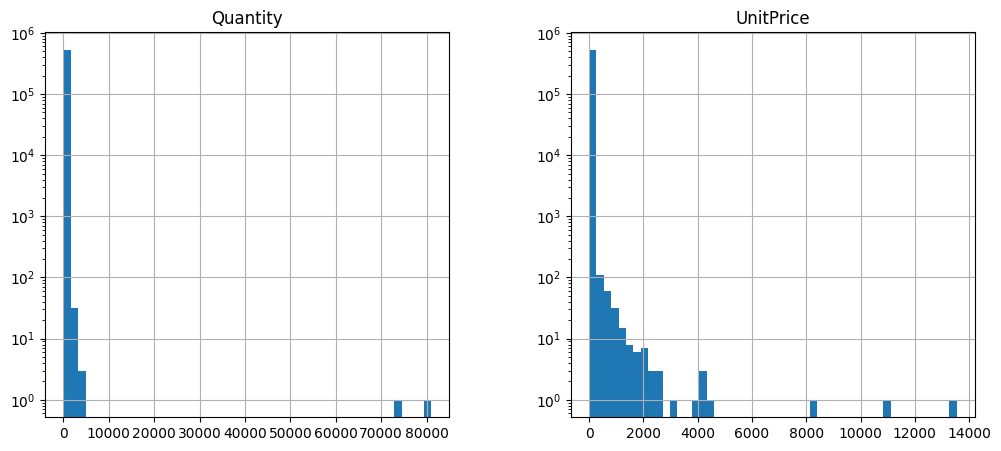

In [ ]:
df[['Quantity', 'UnitPrice']].hist(bins=50, figsize=(12, 5), layout=(1, 2), log=True)
plt.show()

Drop rows with negative values

In [ ]:
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,decimal_part
count,530104.000000,530104,530104.000000,530104.000000,397884.0
mean,10.542037,2011-07-04 20:16:05.225087744,3.907625,11479.646222,0.0
min,1.000000,2010-12-01 08:26:00,0.001000,0.000000,0.0
25%,1.000000,2011-03-28 12:22:00,1.250000,12352.000000,0.0
50%,3.000000,2011-07-20 12:58:00,2.080000,14388.000000,0.0
75%,10.000000,2011-10-19 12:39:00,4.130000,16265.000000,0.0
max,80995.000000,2011-12-09 12:50:00,13541.330000,18287.000000,0.0
std,155.524124,NaN,35.915681,6781.976768,0.0


Remove outliers by applying Interquartile Range (IQR) method

In [ ]:
# Function: outlier remove
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Quantity outlier remove
df = remove_outliers_iqr(df, 'Quantity')

# UnitPrice outlier remove
df = remove_outliers_iqr(df, 'UnitPrice')

df[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,442666.000000,442666.000000
mean,4.904070,2.784289
std,4.495069,2.036175
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.100000
75%,8.000000,3.750000
max,23.000000,8.500000


            Quantity      UnitPrice
count  442666.000000  442666.000000
mean        4.904070       2.784289
std         4.495069       2.036175
min         1.000000       0.001000
25%         1.000000       1.250000
50%         3.000000       2.100000
75%         8.000000       3.750000
max        23.000000       8.500000


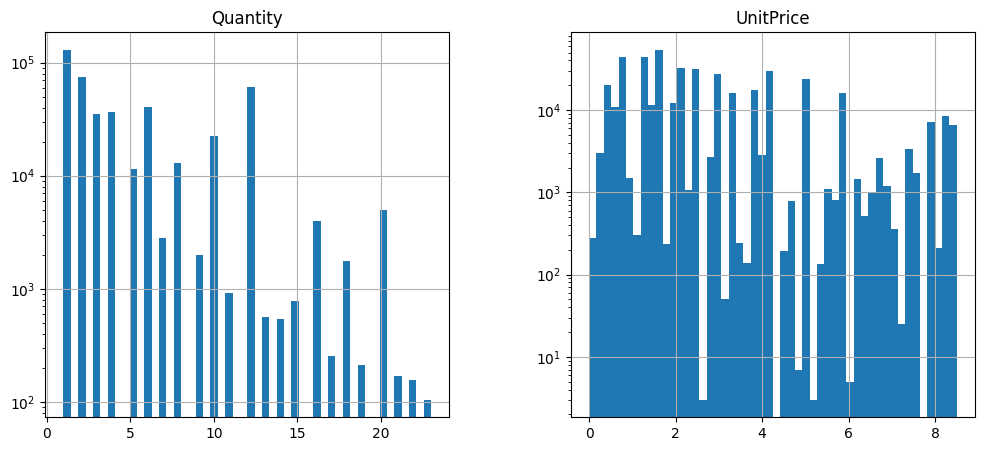

In [ ]:
print(df[['Quantity', 'UnitPrice']].describe())

df[['Quantity', 'UnitPrice']].hist(bins=50, figsize=(12, 5), layout=(1, 2), log=True)
plt.show()

# Exporatory data analysis (EDA)

## Calculating RFM Metrics
1. Recency: How recently the customer made a purchase

2. Frequency: How often the customer makes a purchase

3. Monetary: How much the customer spends

1. Recency

In [ ]:
# Creating Total_Price column
df['Total_Price'] = df['Quantity'] * df['UnitPrice']

# Reference date for recency calculation
reference_date = df['InvoiceDate'].max()

# Creating new DataFrame, grouping by CustomerID and calculating RFM metrics
df_rfm = df.groupby('CustomerID').agg({
    # Calculate Recency as the number of days since the most recent purchase for each customer
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency (days since last purchase)

    # Count the number of invoices for each customer to calculate Frequency
    'InvoiceNo': 'count',                                      # Frequency (number of transactions)

    # Calculate the total spending of each customer by summing the 'Total_Price'
    'Total_Price': 'sum'                                       # Monetary (total money spent)
})

# Rename columns for clarity
df_rfm = df_rfm.rename(columns={
    'InvoiceDate': 'Recency',      # Renaming InvoiceDate column as Recency
    'InvoiceNo': 'Frequency',      # Renaming InvoiceNo column as Frequency
    'Total_Price': 'Monetary'      # Renaming Total_Price column as Monetary
}).reset_index()

# Display the first few rows of the RFM DataFrame
df_rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,0,0,116226,859250.74
1,12347,1,141,2866.77
2,12348,248,1,17.00
3,12349,18,61,1155.75
4,12350,309,15,274.00


In [ ]:
# Saving preprocessed dataset
df_rfm.to_csv('df_rfm.csv', index=False)

# Display the first few rows of the RFM DataFrame
df.head()

# Normalize the Data

To ensure that the clustering algorithm does not get biased by different scales of data, we normalize the RFM features.

In [ ]:
# Normalization by using Min-Max scaling
